In [1]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
import os
from torchvision.transforms import ToTensor
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.batchnorm import _BatchNorm
import torchmetrics
import time
import datetime
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size=1
image_count=50
img_size=256
from torchinfo import summary
tf = ToTensor()

In [4]:
class CustomDataset(Dataset):
    def __init__(self, id,image_list, label_list):
        self.img_path = image_list

        self.label = label_list
        self.id=id

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        id_tensor=self.id[idx]
        image_tensor = self.img_path[idx]
    
        label_tensor =  self.label[idx]
        return image_tensor, label_tensor

test_data=pd.read_csv('../../data/mteg_data/supine_frame/test_label.csv') 
file_path='../../data/mteg_data/supine_frame/test/'
test_image_list=[]
for i in range(len(test_data)):
    file_name=test_data.loc[i]['File Name']
    id=file_name[:file_name.find('_')]
    test_image_list.append(file_path+id)
label_data=pd.read_csv('../../data/mteg_data/supine_frame/label.csv')  
test_label_list=[]
test_id_list=[]
test_image_tensor = torch.empty((len(test_image_list),image_count,3, img_size, img_size))
for i in tqdm(range(len(test_image_list))):
    folder_name=os.path.basename(test_image_list[i])
    dst_label=label_data.loc[label_data['일련번호']==int(folder_name[:-1])]
    dst_label=dst_label.loc[dst_label['구분값']==int(folder_name[-1])].reset_index()
    label=int(dst_label.loc[0]['OTE 원인'])
    test_id_list.append(folder_name)
    test_label_list.append(label-1) 
    image_file_list = glob(test_image_list[i]+'/*.jpg')
    if len(image_file_list)>image_count:
        image_index = torch.randint(low=0, high=len(
            image_file_list)-image_count, size=(1,))
        count = 0
        for index in range(image_count):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
    else:
        count = 0
        for index in range(len(image_file_list)):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
        for j in range(image_count-count):
            image = 1-tf(Image.open(image_file_list[j]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1


test_label_list=[1 if x==2 else x for x in test_label_list]

test_dataset = CustomDataset(test_id_list,test_image_tensor, F.one_hot(torch.tensor(test_label_list).to(torch.int64)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/133 [00:00<?, ?it/s]

In [3]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out


class ReAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
    
class LeFF(nn.Module):
    
    def __init__(self, dim = 192, scale = 4, depth_kernel = 3):
        super().__init__()
        
        scale_dim = dim*scale
        self.up_proj = nn.Sequential(nn.Linear(dim, scale_dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(scale_dim),
                                    nn.GELU(),
                                    Rearrange('b c (h w) -> b c h w', h=14, w=14)
                                    )
        
        self.depth_conv =  nn.Sequential(nn.Conv2d(scale_dim, scale_dim, kernel_size=depth_kernel, padding=1, groups=scale_dim, bias=False),
                          nn.BatchNorm2d(scale_dim),
                          nn.GELU(),
                          Rearrange('b c h w -> b (h w) c', h=14, w=14)
                          )
        
        self.down_proj = nn.Sequential(nn.Linear(scale_dim, dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(dim),
                                    nn.GELU(),
                                    Rearrange('b c n -> b n c')
                                    )
        
    def forward(self, x):
        x = self.up_proj(x)
        x = self.depth_conv(x)
        x = self.down_proj(x)
        return x
    
    
class LCAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        q = q[:, :, -1, :].unsqueeze(2) # Only Lth element use as query

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [5]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


  
class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)

        x = self.temporal_transformer(x)
        

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x)
    
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups
        
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

In [17]:
model = ViViT(img_size, 16, 2, image_count)
model.cuda(0)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
model.load_state_dict(torch.load('../../model/supine_mteg/vivit/ep_vivit_26.pt'))

<All keys matched successfully>

In [18]:
start = time.time()
d = datetime.datetime.now()
now_time = f"{d.year}-{d.month}-{d.day} {d.hour}:{d.minute}:{d.second}s"
print(f'[Predict Start]')
print(f'Predict Start Time : {now_time}')
total_y = torch.zeros((len(test_dataloader), 2)).to(device)
total_prob = torch.zeros((len(test_dataloader), 2)).to(device)

count=0
val_running_loss=0.0
acc_loss=0
test=tqdm(test_dataloader)
path_list=[]
model.eval()
with torch.no_grad():
    for x,y in test:
        y = y.to(device).float()
        x=x.to(device).float()
        predict = model(x).to(device)
        cost = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
        acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
        val_running_loss+=cost.item()
        acc_loss+=acc
        prob_pred = predict.softmax(dim=1)
        total_y[count] = y.squeeze(dim=1)
        total_prob[count] = prob_pred
        count += 1
end = time.time()
d = datetime.datetime.now()
now_time = f"{d.year}-{d.month}-{d.day} {d.hour}:{d.minute}:{d.second}"
print(f'Predict Time : {now_time}s Time taken : {end-start}')
print(f'[Predict End]')

[Predict Start]
Predict Start Time : 2024-4-30 10:19:15s


  0%|          | 0/133 [00:00<?, ?it/s]

Predict Time : 2024-4-30 10:19:21s Time taken : 6.323937892913818
[Predict End]


total AUC score= 0.5


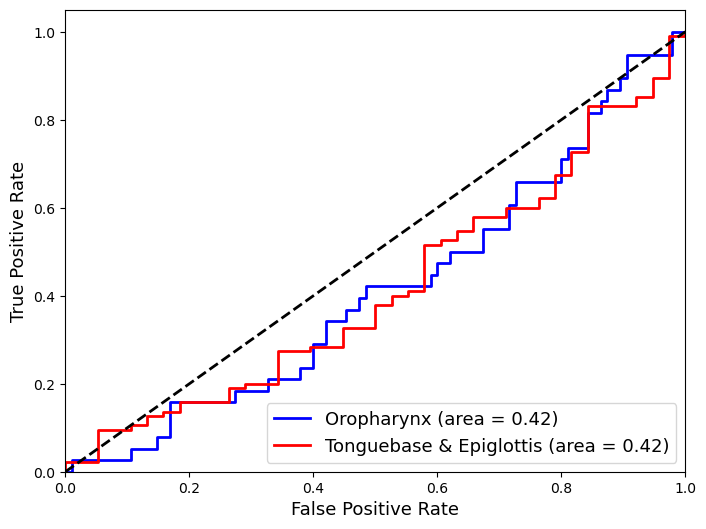

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(total_y.cpu()[:, i], total_prob.cpu()[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
test_score=roc_auc_score(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1), multi_class='ovr')
# 모든 클래스의 ROC 곡선을 그립니다.
plt.figure(figsize=(8, 6))
colors = ['blue', 'red']
class1=['Oropharynx','Tonguebase & Epiglottis']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class1[i]} (area = {roc_auc[i]:.2f})')
print(f'total AUC score= {test_score}')   
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.legend(loc="lower right",fontsize=13)
plt.show()

total f1-score= 0.41666666666666663


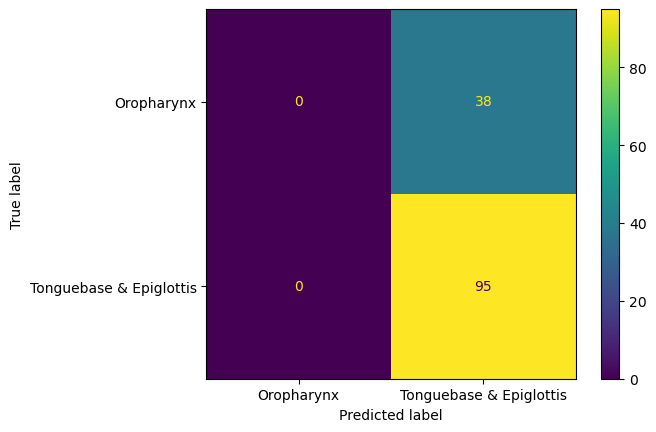

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
cm = confusion_matrix(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1))
classes = ['Oropharynx','Tonguebase & Epiglottis']

cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()
f1 = f1_score(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1), average='macro')

print(f'total f1-score= {f1}') 